# Churn-prediction model



## Task: 
Based on information about the telecom operator's customers, build a model capable of predicting their churn.

### Description of services:
#### Main services:
1. Landline telephone service. It is possible to connect a telephone to multiple lines simultaneously.
2. Internet. Connection can be of two types: through a telephone line (DSL, or Digital Subscriber Line) or fiber optic cable.

#### Additional services:
1. Internet security: antivirus (DeviceProtection) and blocking of unsafe sites (OnlineSecurity);
2. Dedicated technical support line (TechSupport);
3. Cloud storage for data backup (OnlineBackup);
4. Streaming TV (StreamingTV) and movie catalog (StreamingMovies).

## Description of datasets:

* contract.csv - information about the contract;
* personal.csv - personal data of the customer;
* internet.csv - information about internet services;
* phone.csv - information about telephony services.

## Description of data:

* BeginDate - date of service start
* EndDate - date of service end
* Type - payment type: monthly, yearly, etc.
* PaperlessBilling - paperless payment
* PaymentMethod - payment method
* MonthlyCharges - monthly expenses for services
* TotalCharges - total money spent on services
* Dependents - presence of dependents
* Senior Citizen - presence of pensioner status by age
* Partner - presence of spouse(s)
* MultipleLines - presence of ability to conduct parallel lines during a call

Information about contracts is valid as of February 1, 2020.

### Target: 'EndDate'

### The main metric: ROC-AUC 

### Additional metric: Accuracy

### Goal for the main metric ROC-AUC >= 0.88

## План работ:

1. Data reviewing.

* Visual data overview.
* Identifying errors, omissions, and duplicates.
* Interim conclusion.

2. Data preprocessing and EDA.

* Combining data into a single working dataset.
* Removing identified errors, omissions, and duplicates.
* Changing data types to optimize model performance.
* Analyzing data to identify errors, patterns, peculiarities, and anomalies, followed by their normalization.
* Preparing features for the model, including the target.
* Analyzing multicollinearity of features and correlation with the target.
* Splitting the dataset into samples.
* Preparing categorical data (encoding, balancing, scaling).
* Interim conclusion.

3. Traning models.

* Training and comparison of several models on cross-validation with hyperparameters selected through Randomsearch.
* Analysis of metrics and selection of an effective working model.
* Interim conclusion.

4. Testing models.

* Testing on a test sample.
* Interim conclusion.

5. Overall conclusion.

## 1. Data reviewing

### Import the libraries and tools.

In [1]:
%%time
!pip install catboost
!pip install lightgbm
!pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU times: user 150 ms, sys: 43.2 ms, total: 194 ms
Wall time: 22.5 s


In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

import warnings
import time
from datetime import datetime

pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore')

### Load datasets.

In [3]:
try:
    contract = pd.read_csv('/content/contract.csv')
    internet = pd.read_csv('/content/internet.csv')
    personal = pd.read_csv('/content/personal.csv')
    phone = pd.read_csv('/content/phone.csv')

except:
    contract = pd.read_csv('C:/Users/Vladimir Abramov/Downloads/datasets/final_provider/contract.csv')
    internet = pd.read_csv('C:/Users/Vladimir Abramov/Downloads/datasets/final_provider/internet.csv')
    personal = pd.read_csv('C:/Users/Vladimir Abramov/Downloads/datasets/final_provider/personal.csv')
    phone = pd.read_csv('C:/Users/Vladimir Abramov/Downloads/datasets/final_provider/phone.csv')

### Data reviewing.

In [4]:
dataframes = {
    'contract': contract,
    'internet': internet,
    'personal': personal,
    'phone': phone
}

for i, df in dataframes.items():
    print('------------- Dataset:', i, '-------------')
    display(df.head(3))
    print(df.info())
    print()
    print('Numbers of duplicates:', df.duplicated().sum())
    print()

------------- Dataset: contract -------------


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Numbers of duplicates: 0

------------- Dataset: internet -------------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Numbers of duplicates: 0

------------- Dataset: personal -------------


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Numbers of duplicates: 0

------------- Dataset: phone -------------


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Numbers of duplicates: 0



Let's check the categorical values of non-boolean type for errors.

In [5]:
print(contract['Type'].unique())

['Month-to-month' 'One year' 'Two year']


In [6]:
print(contract['PaymentMethod'].unique())

['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [7]:
print(internet['InternetService'].unique()) 

['DSL' 'Fiber optic']


In [8]:
print(personal['gender'].unique())  

['Female' 'Male']


Let's look at the anomaly of the data type in contract ['TotalCharges'].

In [9]:
contract['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

In [10]:
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


### Conclusion:
Four datasets of different sizes have been taken into account due to the fact that subscribers use different sets of services.

From the preliminary data review, the following has been identified:
1. Different notation of feature names, it is necessary to bring to a single notation;
2. Non-compliance of data type with content, it is necessary to bring BeginDate, EndDate to datetime, and TotalCharges to float32;
3. In the contract ['TotalCharges'] column, 11 records instead of data space were identified, due to which the data type is object;
4. In the datasets, Boolean categorical features have different notation Yes/No, 1/0 - bring to a common binary form 1/0;
5. In the datasets before merging, no missing values or duplicates were identified;
6. No errors were found in categorical values of non-boolean type;
7. The target feature EndDate in the date format, the target will be brought to a binary form where '1' are subscribers who left in EndDate with a date, and '0' are active subscribers with a zero value in EndDate.

## 2. Data preprocessing and EDA.

### Let's combine the datasets into one dataframe.

In [11]:
data = contract.merge(personal, on = 'customerID')
data = data.merge(internet, on = 'customerID', how = 'left')
data = data.merge(phone, on = 'customerID', how = 'left')

In [12]:
data.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In the combined dataset, we can see the presence of missing values, which are caused by the fact that subscribers use different sets of services. We will fill them in with 'No'.

In [14]:
data = data.fillna('No')

In [15]:
data.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


There are no duplicates.

In [17]:
data.duplicated().sum()

0

Upon preliminary data review, gaps in TotalCharges were identified in the form of a gap, the data is missing because the start of the contract falls on the date of the dataset cut 01.02.2022. The sample is small and, in order not to lose data, we will equate them to 0.

In [18]:
data['TotalCharges'] = data['TotalCharges'].replace(' ', 0).astype('float32')

In [19]:
data[data['TotalCharges'] == 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0,Male,0,No,Yes,No,No,No,No,No,No,No,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0,Female,0,Yes,Yes,No,No,No,No,No,No,No,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


We will bring the feature names to lowercase with words separated by underscores.

In [20]:
data.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

In [21]:
data = data.rename({'customerID': 'customer_id', 
                    'BeginDate': 'begin_date', 
                    'EndDate': 'end_date', 
                    'Type': 'type', 
                    'PaperlessBilling': 'paperless_billing', 
                    'PaymentMethod': 'payment_method', 
                    'MonthlyCharges': 'monthly_charges', 
                    'TotalCharges': 'total_charges',
                    'gender': 'gender',
                    'SeniorCitizen': 'senior_citizen',                                    
                    'Partner': 'partner',                   
                    'Dependents': 'dependents',                   
                    'InternetService': 'internet_service',
                    'OnlineSecurity': 'online_security',
                    'OnlineBackup': 'online_backup',
                    'DeviceProtection': 'device_protection',
                    'TechSupport': 'tech_support',
                    'StreamingTV': 'streaming_tv',
                    'StreamingMovies': 'streaming_movies',
                    'MultipleLines': 'multiple_lines'
                   }, axis='columns')

data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [22]:
data.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.850000,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.500000,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.150002,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


In [23]:
data['monthly_charges'] = data['monthly_charges'].astype('float32')
data['senior_citizen'] = data['senior_citizen'].astype('int32')

In [24]:
data['begin_date'] = data['begin_date'].astype('datetime64[M]')
data['end_date'] = pd.to_datetime(data['end_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.date
data['end_date'] = data['end_date'].fillna('2020-02-01')
data['end_date'] = data['end_date'].astype('datetime64[M]')

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float32       
 7   total_charges      7043 non-null   float32       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int32         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

### EDA

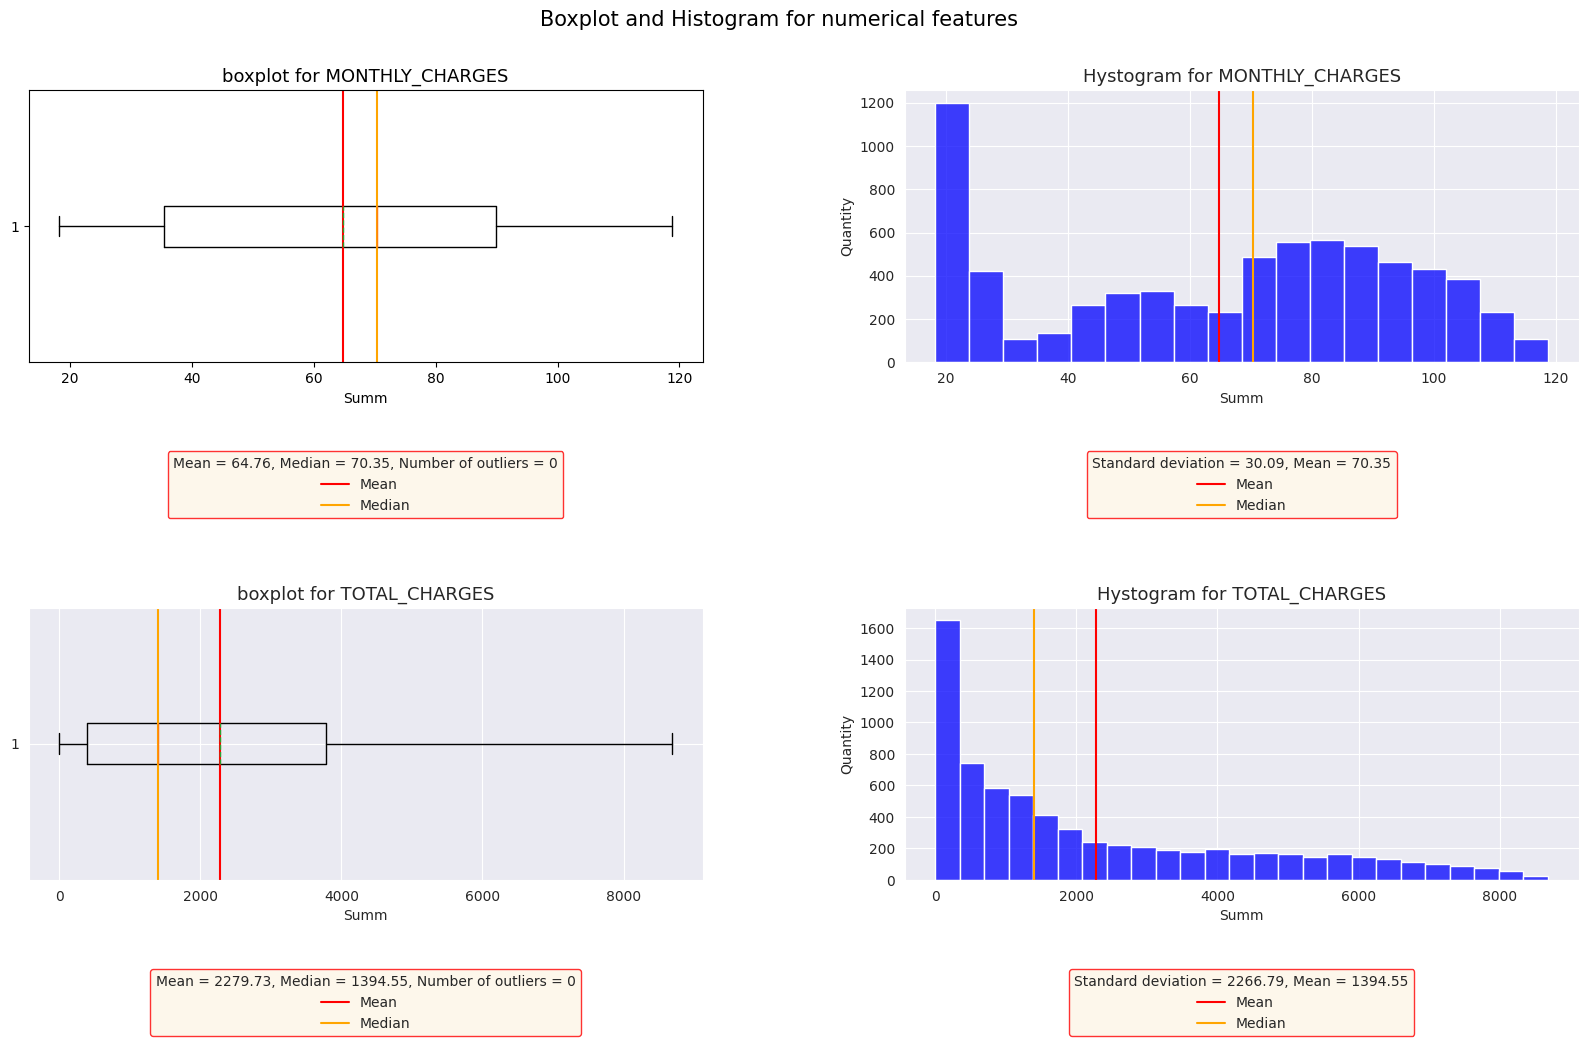

In [26]:
position = 0
plt.figure(figsize=[20, 10])
plt.subplots_adjust(top=0.90, 
                    wspace=0.3, 
                    hspace=0.90)
plt.suptitle('Boxplot and Histogram for numerical features', 
             fontsize=15)

for column_name in ['monthly_charges', 'total_charges']:
    position += 1
    plt.subplot(2, 2, position)
    plt.title(f'boxplot for {column_name.upper()}', fontsize=13)
    sns.set_style('darkgrid')
    boxplot = plt.boxplot(data[column_name].values, 
                          vert=False, 
                          meanline=True, 
                          showmeans=True)
    outliers = list(boxplot['fliers'][0].get_data()[1])
    plt.xlabel('Summ')
    plt.axvline(np.mean(data[column_name]), 
               color='r', 
               linestyle='-',
               label='Mean')
    plt.axvline(np.median(data[column_name]), 
                color='orange', 
                linestyle='-',
                label='Median')
    median = np.mean(data[column_name])
    mean = np.median(data[column_name])
    plt.legend(title=f'Mean = {np.mean(data[column_name]):.2f}, Median = {np.median(data[column_name]):.2f}, Number of outliers = {len(outliers)}',
               loc='center', 
               edgecolor = 'r',
               facecolor = 'oldlace',
               bbox_to_anchor=(0.5, -0.45))
    position += 1
    plt.subplot(2, 2, position)
    sns.set_style('darkgrid')
    plt.title(f'Hystogram for {column_name.upper()}', 
              fontsize=13)
    sns.histplot(data=data[column_name], 
                 color='b', 
                 kde=False)
    plt.ylabel('Quantity')
    plt.xlabel('Summ')
    plt.axvline(np.mean(data[column_name]), 
                color='r', 
                linestyle='-',
                label='Mean')
    plt.axvline(np.median(data[column_name]), 
                color='orange', 
                linestyle='-',
                label='Median')
    std = data[column_name].std()
    plt.legend(title=f'Standard deviation = {std:.2f}, Mean = {mean:.2f}', 
               loc='center', 
               edgecolor = 'r',
               facecolor = 'oldlace',
               bbox_to_anchor=(0.5, -0.45))
plt.show();


For the column monthly_charges:
* The median is greater than the mean, which means the dataset has a slight skewness to the left towards additional/anomalous values (negative skewness).
* No outliers were detected.

For the column total_charges:
* The median is less than the mean, which means the dataset has a skewness to the right towards additional/anomalous values (positive skewness).
* No outliers were detected.

The abnormally high values at the beginning of the histogram for the column monthly_charges may indicate that a certain initial tariff is popular, or that a bonus/discount program was in effect at the time of connection. For the column total_charges, users either used the services for a short time or had a limited set of services.

Let's look at the distribution of the number of customers coming in by year.

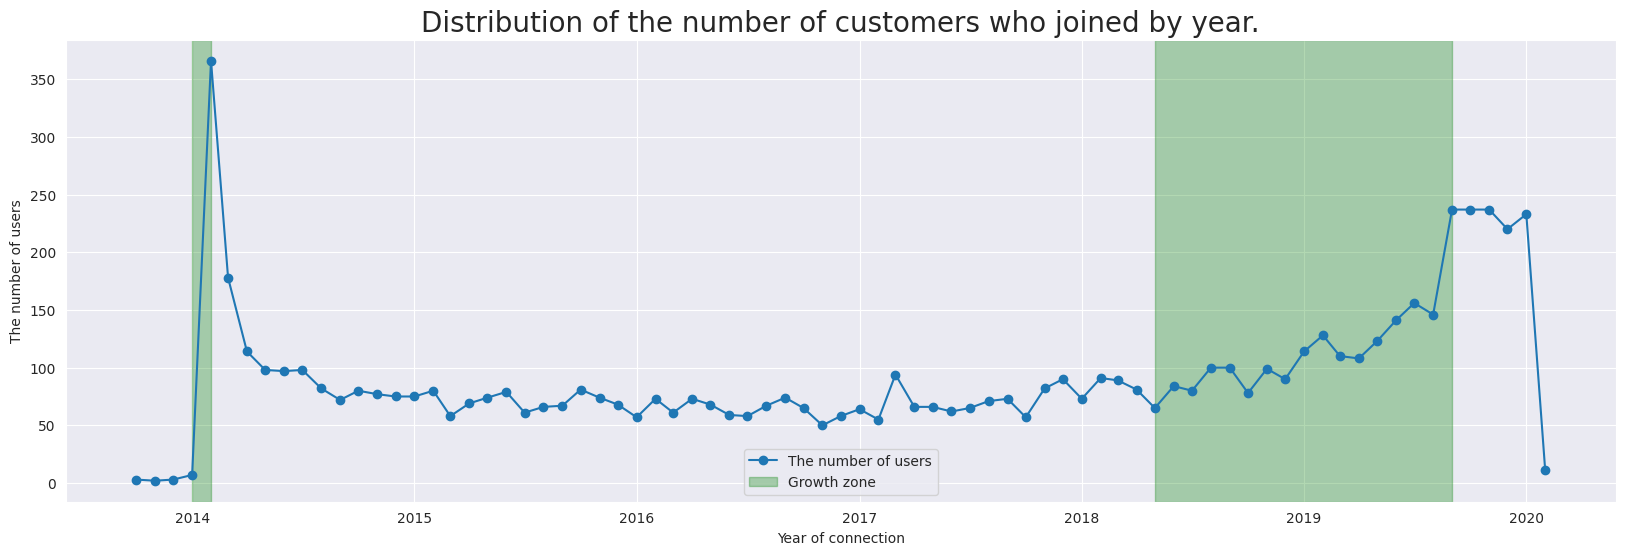

In [27]:
plt.figure(figsize=(20, 6))
plt.title('Distribution of the number of customers who joined by year.', 
          fontsize=20)
plt.ylabel('The number of users')
plt.xlabel('Year of connection')
plt.plot(data.join(data.index.to_frame()).groupby('begin_date')['customer_id'].count(),
         'o-',
         label='The number of users',
         alpha=1)
plt.axvspan('2014-01-01', 
            '2014-02-01', 
            color='green', 
            label='Growth zone', 
            alpha=0.3)
plt.axvspan('2018-05-01', 
            '2019-09-01', 
            color='green', 
            alpha=0.3)
plt.grid(True)
plt.legend();

The most active customers joined in the period from January to February 2014 and in the period from May 2018 to September 2019. 

The growth in the number of customers in these periods could have been associated with a promotional campaign. So in the second case, the campaign could have been organized to attract new customers. The sharp drop in the figures in 2020 is due to the limited recruitment timeframe, i.e. the data is truncated (the dataset is current as of February 1, 2020). 

We will now consider the distribution of the number of customers who left by year.

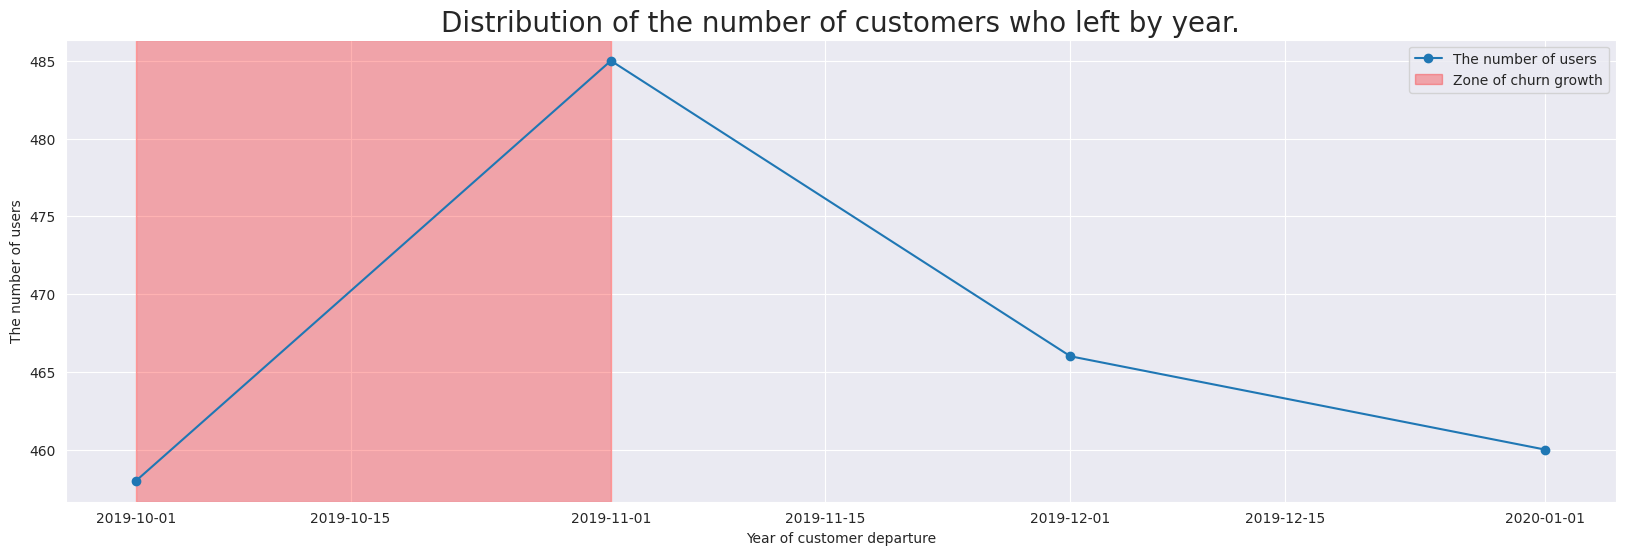

In [28]:
plt.figure(figsize=(20, 6))
plt.title('Distribution of the number of customers who left by year.', fontsize=20)
plt.ylabel('The number of users')
plt.xlabel('Year of customer departure')
plt.plot(data[data['end_date'] != '2020-02-01'].join(data.index.to_frame()).groupby('end_date')['customer_id'].count(),
         'o-',
         label='The number of users',
         alpha=1)
plt.axvspan('2019-10-01', 
            '2019-11-01', 
            color='red', 
            label='Zone of churn growth',  
            alpha=0.3)
plt.grid(True)
plt.legend();

Let's see which services were the most popular. 

To build a graph, let's assemble intermediate tables.

In [29]:
data['begin_year'] = data['begin_date'].dt.year
data['end_year'] = data['end_date'].dt.year
pvt_internet = data[data['internet_service'] != 'No'].groupby(('begin_year'))['internet_service'].count()
pvt_telephone = data[data['multiple_lines'] != 'No'].groupby(('begin_year'))['multiple_lines'].count()
df_with_services = pd.DataFrame({'begin_year': pvt_internet.index, 'internet': pvt_internet.values})
df_telephone = pd.DataFrame({'begin_year': pvt_telephone.index, 'telephone': pvt_telephone.values})
df_with_services = df_with_services.merge(df_telephone, 
                                          on='begin_year', 
                                          how='outer')
for service in (['online_security', 
                 'online_backup', 
                 'device_protection', 
                 'tech_support', 
                 'streaming_tv', 
                 'streaming_movies']):
    pvt = data[data[f'{service}'] != 'No'].groupby(('begin_year'))[f'{service}'].count()
    df_with_one_service = pd.DataFrame({'begin_year': pvt.index, f'{service}': pvt.values})
    df_with_services = df_with_services.merge(df_with_one_service, 
                                              on='begin_year', 
                                              how='outer')
df_with_services.index = pvt_internet.index
df_with_services.drop('begin_year', 
                      axis=1, 
                      inplace=True)

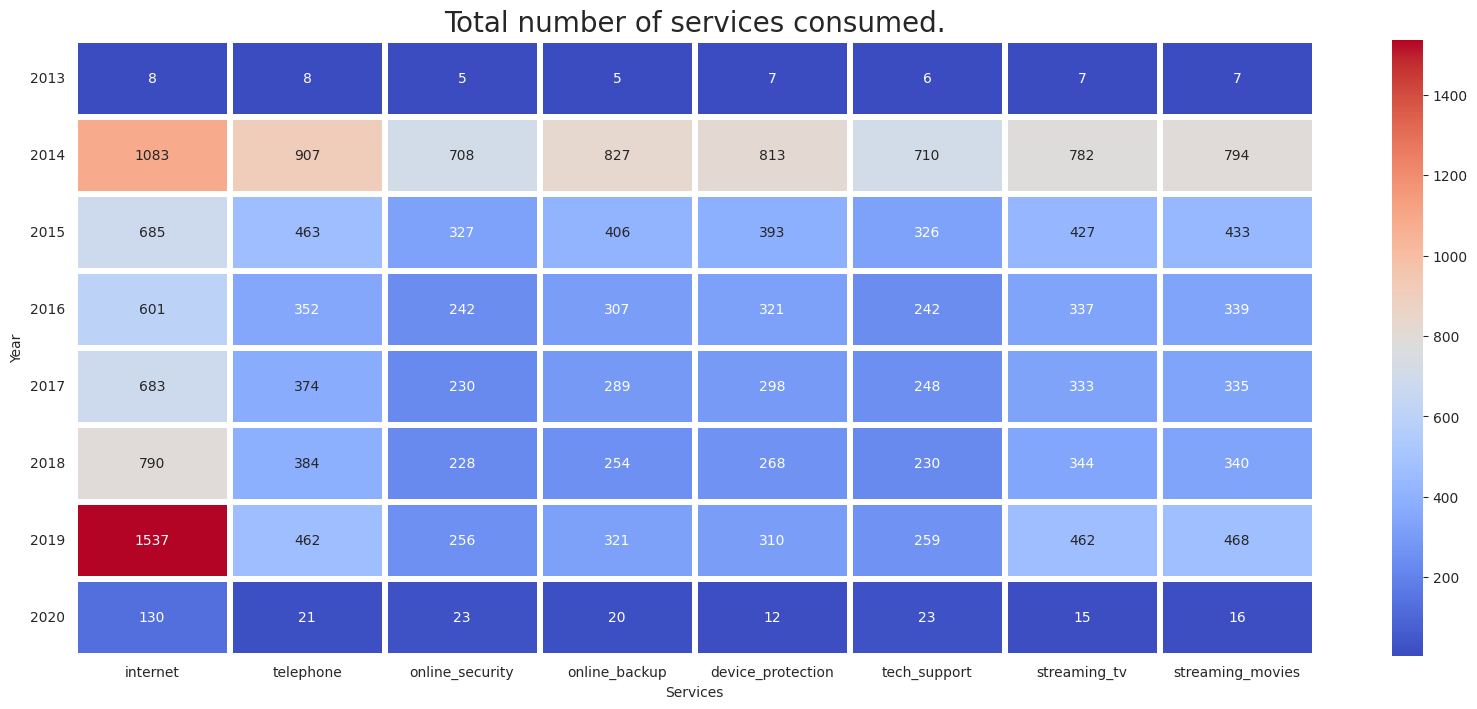

In [30]:
fig, ax = plt.subplots(figsize=(20,8))
plt.title('Total number of services consumed.', 
          fontsize=20)
ax = sns.heatmap(df_with_services, 
                 annot=True, 
                 cmap='coolwarm', 
                 linewidths=3, 
                 fmt='.4g')
ax.set_yticklabels([i for i in df_with_services.index], 
                   rotation=0)
plt.ylabel('Year')
plt.xlabel('Services')
plt.grid(True);

As we can see, there is an increase in the number of services consumed in 2014 and from 2018 to 2019. 

But in general, the number of services, except for the internet, has significantly decreased from 2014 to 2019. The reason for the decrease may be the high cost compared to competitors, the timely update of technologies, and as a result, the poor quality of services. 

From 2018 to 2019, it was possible to increase the number of services used. Most likely, the company launched a promotional campaign. 

Let's see which services were the most popular.

In [31]:
total = []
for service in df_with_services.columns:
    total.append(df_with_services[service].sum())

In [32]:
df_with_total = pd.DataFrame({'services': df_with_services.columns, 'total': total})

In [33]:
del df_with_services

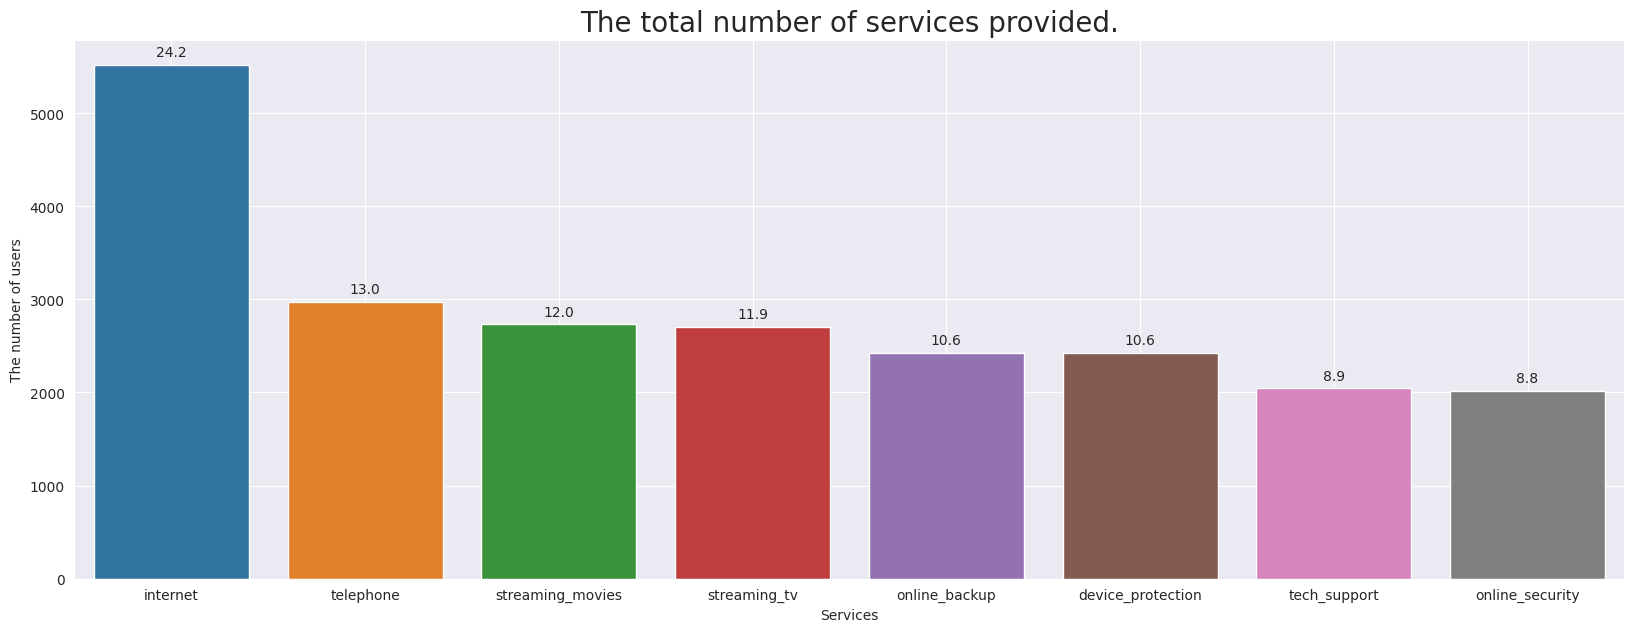

In [34]:
df_with_total.sort_values(by='total', 
                          ascending=False, 
                          inplace=True)
plt.figure(figsize=(20, 7))
plt.title('The total number of services provided.', 
          fontsize=20)
pop_services = sns.barplot(x='services', 
                           y='total', 
                           data=df_with_total)
for p in pop_services.patches:
    pop_services.annotate(format(p.get_height() / df_with_total['total'].sum() * 100, '.1f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', 
                          va = 'center', 
                          xytext = (0, 9), 
                          textcoords = 'offset points')
plt.ylabel('The number of users')
plt.xlabel('Services')
plt.grid(True);

As we can see, the most popular services among users are: 
1. Internet, 
2. Telephony, 
3. Streaming movies, 
4. Streaming TV.

In [35]:
del df_with_total

Let's see which types of internet connection are most successful.

In [36]:
pvt_dsl = data[data['internet_service'] == 'DSL'].groupby(('begin_year'))['internet_service'].count()
pvt_optic = data[data['internet_service'] == 'Fiber optic'].groupby(('begin_year'))['internet_service'].count()
df_with_connection_type = pd.DataFrame({'begin_year': pvt_dsl.index, 'dsl': pvt_dsl.values})
df_optic = pd.DataFrame({'begin_year': pvt_optic.index, 'optic': pvt_optic.values})
df_with_connection_type = df_with_connection_type.merge(df_optic, 
                                                        on='begin_year', 
                                                        how='outer')
df_with_connection_type.index = pvt_dsl.index
df_with_connection_type.drop('begin_year', 
                             axis=1, 
                             inplace=True)

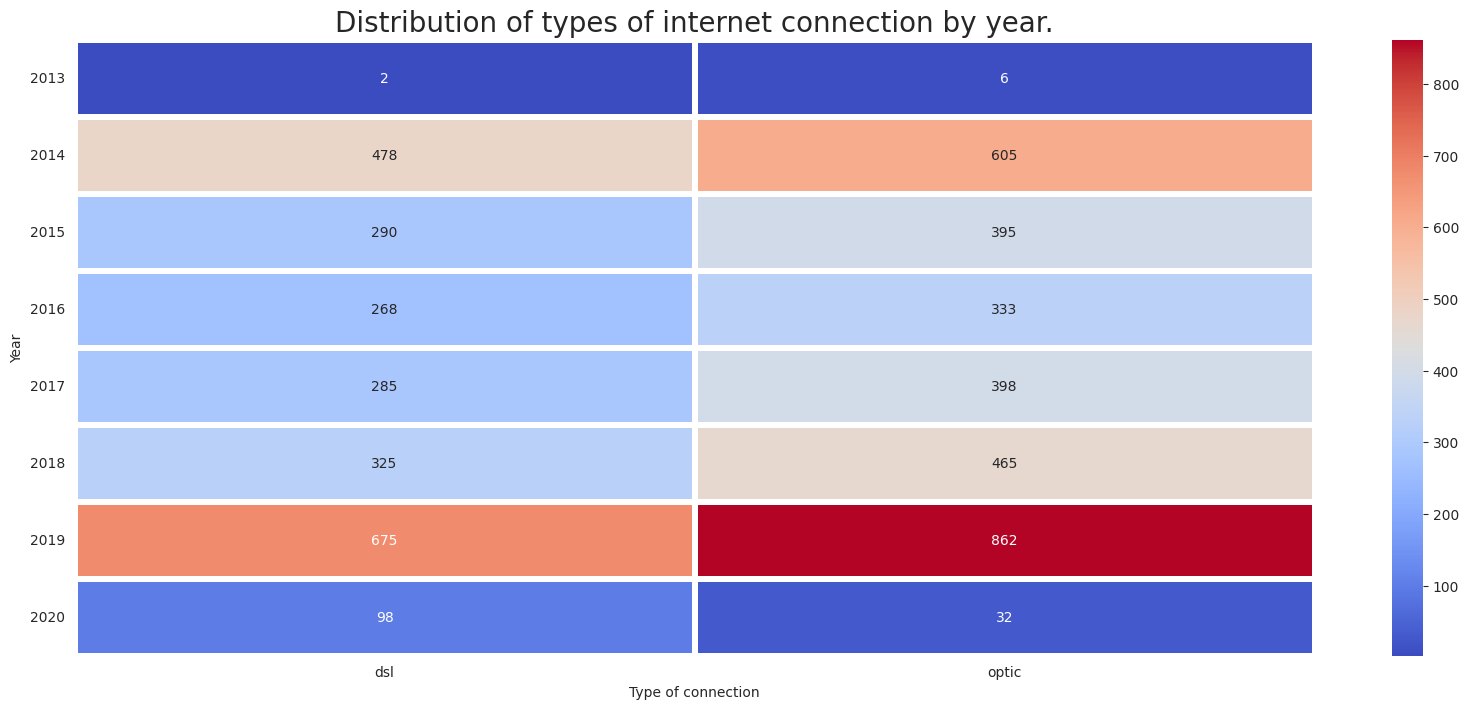

In [37]:
fig, ax = plt.subplots(figsize=(20,8))
plt.title('Distribution of types of internet connection by year.', 
          fontsize=20)
ax = sns.heatmap(df_with_connection_type, 
                 annot=True, 
                 cmap="coolwarm", 
                 linewidths=3, 
                 fmt='.4g')
ax.set_yticklabels([i for i in df_with_connection_type.index], 
                   rotation=0)
plt.ylabel('Year')
plt.xlabel('Type of connection')
plt.grid(True);

Internet is important for people and the number of connections is growing, despite a significant outflow of customers from 2014 to 2015. The most preferred type of connection is fiber optics, the signal quality and speed are better there.

In [38]:
del ax, pvt_dsl, pvt_optic, df_optic, df_with_connection_type

Let's see which type of payment method customers prefer more.

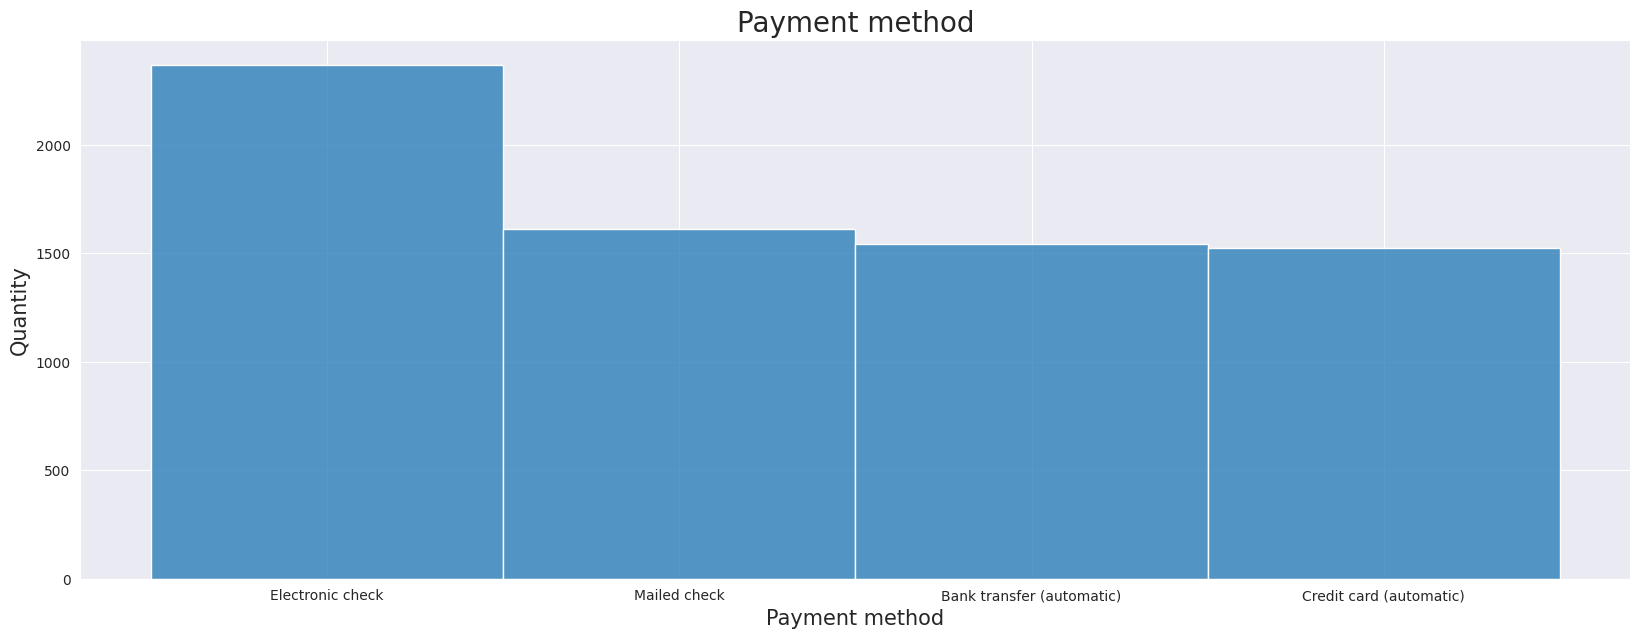

In [39]:
plt.figure(figsize=(20, 7))
plt.title('Payment method', 
          fontsize=20)
sns.histplot(data['payment_method'], 
             kde=False);
plt.ylabel('Quantity', 
           fontsize=15)
plt.xlabel('Payment method', 
           fontsize=15)
plt.grid(True);

We see that the most popular payment method is by electronic check and the least popular is autopayment by credit card.

Let's see which period of payment customers prefer more.

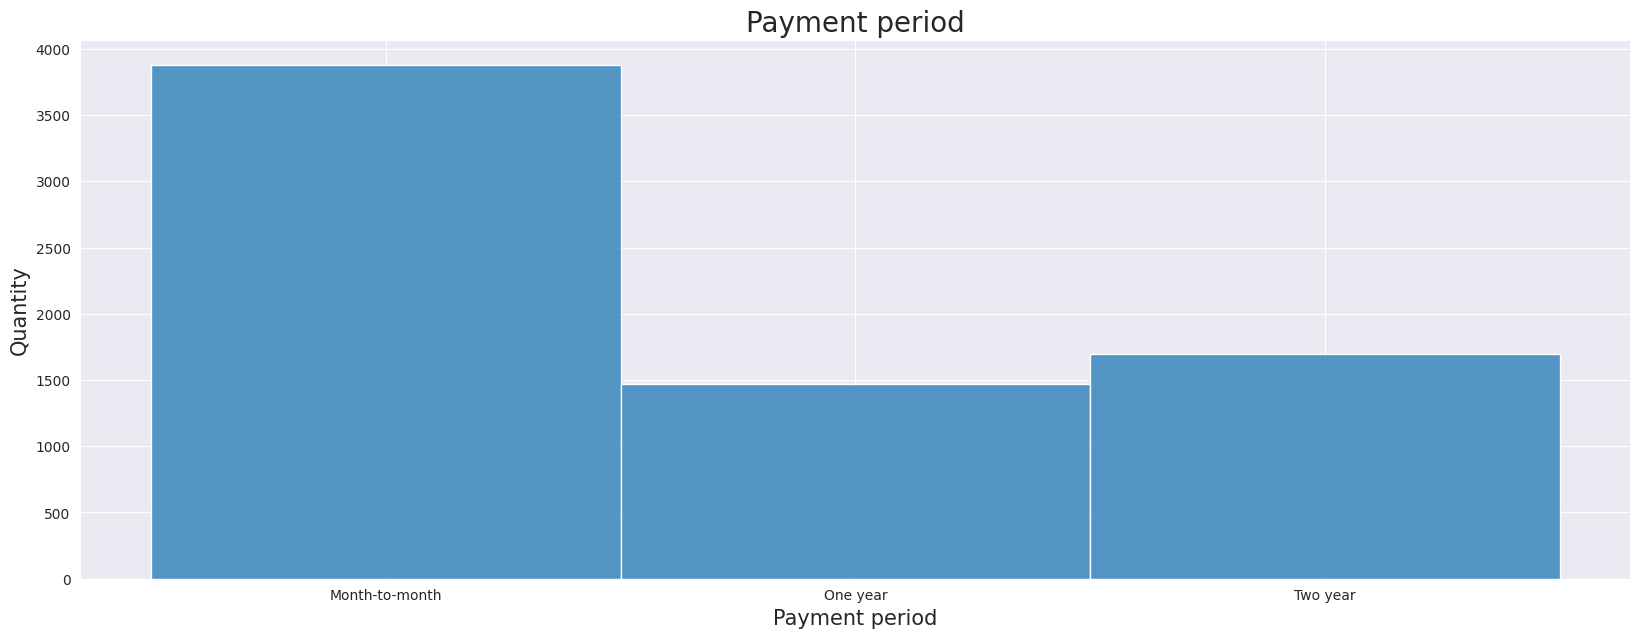

In [40]:
plt.figure(figsize=(20, 7))
plt.title('Payment period', 
          fontsize=20)
sns.histplot(data['type'], 
             kde=False);
plt.ylabel('Quantity', 
           fontsize=15)
plt.xlabel('Payment period', 
           fontsize=15)
plt.grid(True);

Customers prefer the monthly payment type.

Let's look at the popularity of electronic invoicing.

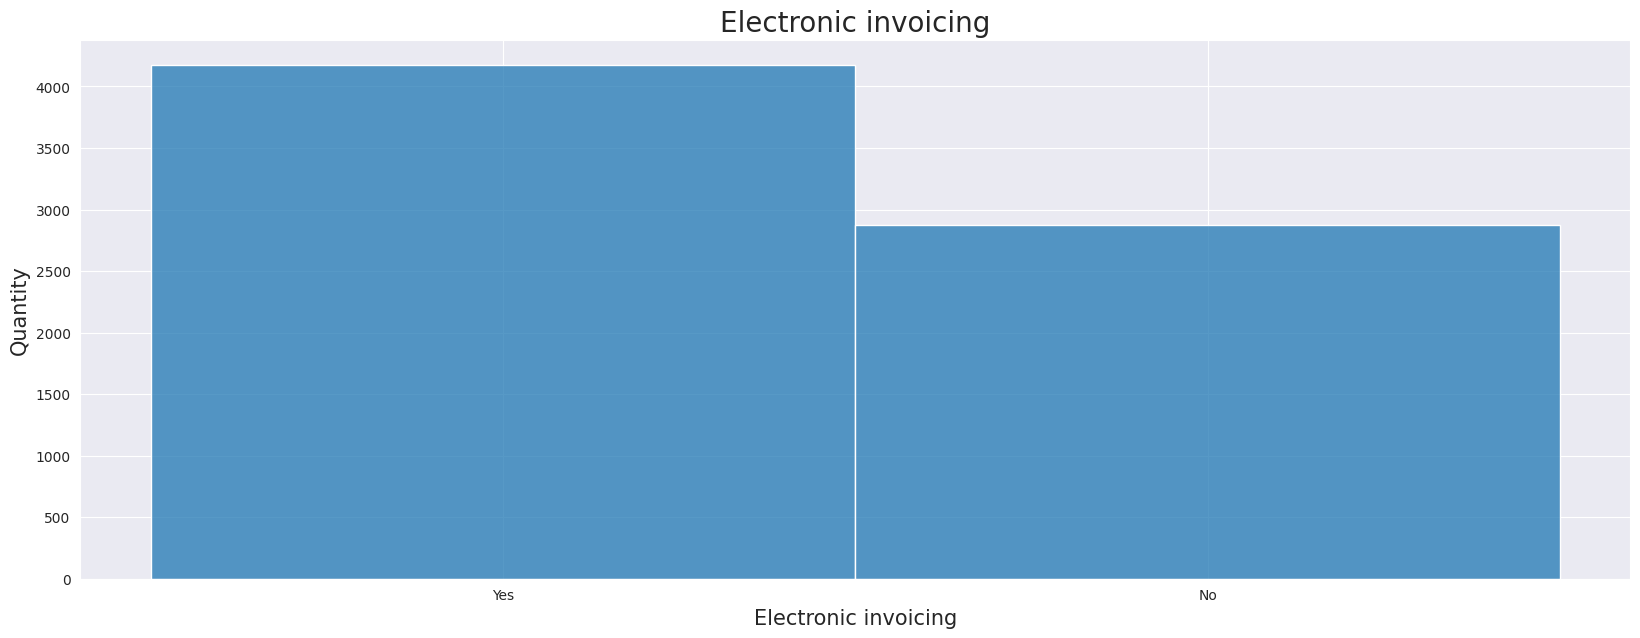

In [41]:
plt.figure(figsize=(20, 7))
plt.title('Electronic invoicing', 
          fontsize=20)
sns.histplot(data['paperless_billing'], 
             kde=False);
plt.ylabel('Quantity', 
           fontsize=15)
plt.xlabel('Electronic invoicing', 
           fontsize=15)
plt.grid(True);

Electronic invoicing is undoubtedly more convenient, it is chosen by the majority.

### Data prerpocessing.

We will add a target binary feature.

In [42]:
data['leaving'] = 1
data.loc[data['end_date'] == '2020-02-01', 'leaving'] = 0

We will add the contract duration.

In [43]:
data['period_days'] = (data['end_date'] - data['begin_date']).dt.days

We will remove non-informative features for further model training.

In [44]:
data.drop(['begin_date', 'end_date', 'begin_year', 'end_year', 'customer_id'], 
          axis=1, 
          inplace=True)

We will convert categorical features to binary.

In [45]:
for column in ['paperless_billing',
               'multiple_lines',
               'dependents',
               'online_security',
               'online_backup',
               'tech_support',
               'streaming_tv',
               'streaming_movies',
               'partner',
               'device_protection']:
    data[column].replace('Yes', 
                         1, inplace=True)
    data[column].replace('No', 
                         0, inplace=True)

We will convert the data type of categorical features to cathegory for further OHE encoding of features.

In [46]:
data['paperless_billing'] = data['paperless_billing'].astype('category')
data['senior_citizen'] = data['senior_citizen'].astype('category')
data['partner'] = data['partner'].astype('category')
data['dependents'] = data['dependents'].astype('category')
data['online_security'] = data['online_security'].astype('category')
data['online_backup'] = data['online_backup'].astype('category')
data['device_protection'] = data['device_protection'].astype('category')
data['tech_support'] = data['tech_support'].astype('category')
data['streaming_tv'] = data['streaming_tv'].astype('category')
data['streaming_movies'] = data['streaming_movies'].astype('category')
data['leaving'] = data['leaving'].astype('category')
data['period_days'] = data['period_days'].astype('int32')
data['multiple_lines'] = data['multiple_lines'].astype('category')
data['type'] = data['type'].astype('category')
data['payment_method'] = data['payment_method'].astype('category')
data['gender'] = data['gender'].astype('category')
data['internet_service'] = data['internet_service'].astype('category')

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               7043 non-null   category
 1   paperless_billing  7043 non-null   category
 2   payment_method     7043 non-null   category
 3   monthly_charges    7043 non-null   float32 
 4   total_charges      7043 non-null   float32 
 5   gender             7043 non-null   category
 6   senior_citizen     7043 non-null   category
 7   partner            7043 non-null   category
 8   dependents         7043 non-null   category
 9   internet_service   7043 non-null   category
 10  online_security    7043 non-null   category
 11  online_backup      7043 non-null   category
 12  device_protection  7043 non-null   category
 13  tech_support       7043 non-null   category
 14  streaming_tv       7043 non-null   category
 15  streaming_movies   7043 non-null   category
 16  multip

We will look at the class balance in the target feature.

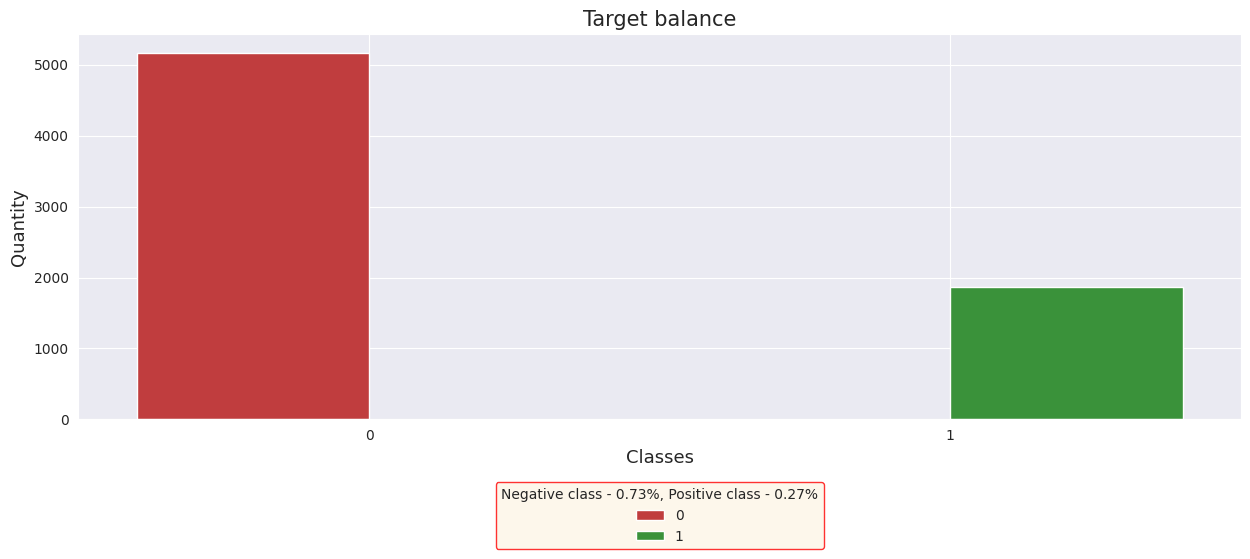

In [48]:
plt.figure(figsize=[15, 5])
plt.title('Target balance', 
          fontsize=15)
palette = {0: 'tab:red', 
           1: 'tab:green'}
sns.set_style('darkgrid')
sns.barplot(x=data['leaving'].value_counts().index,
            y=data['leaving'].value_counts(),
            hue=data['leaving'].value_counts().index,
            palette=palette)
plt.ylabel('Quantity', 
           fontsize=13)
plt.xlabel('Classes', 
           fontsize=13)
plt.grid(True)
negative_class = data['leaving'].value_counts(normalize=True)[0]
positive_class = data['leaving'].value_counts(normalize=True)[1]
plt.legend(title=f'Negative class - {negative_class:.2f}%, Positive class - {positive_class:.2f}%', 
           loc='center', 
           edgecolor = 'r',
           facecolor = 'oldlace',
           bbox_to_anchor=(0.5, -0.25))
plt.show();

As expected, there is an imbalance on the face.

We will build a phi-correlation matrix of the dependence of numerical and categorical features.

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'period_days']


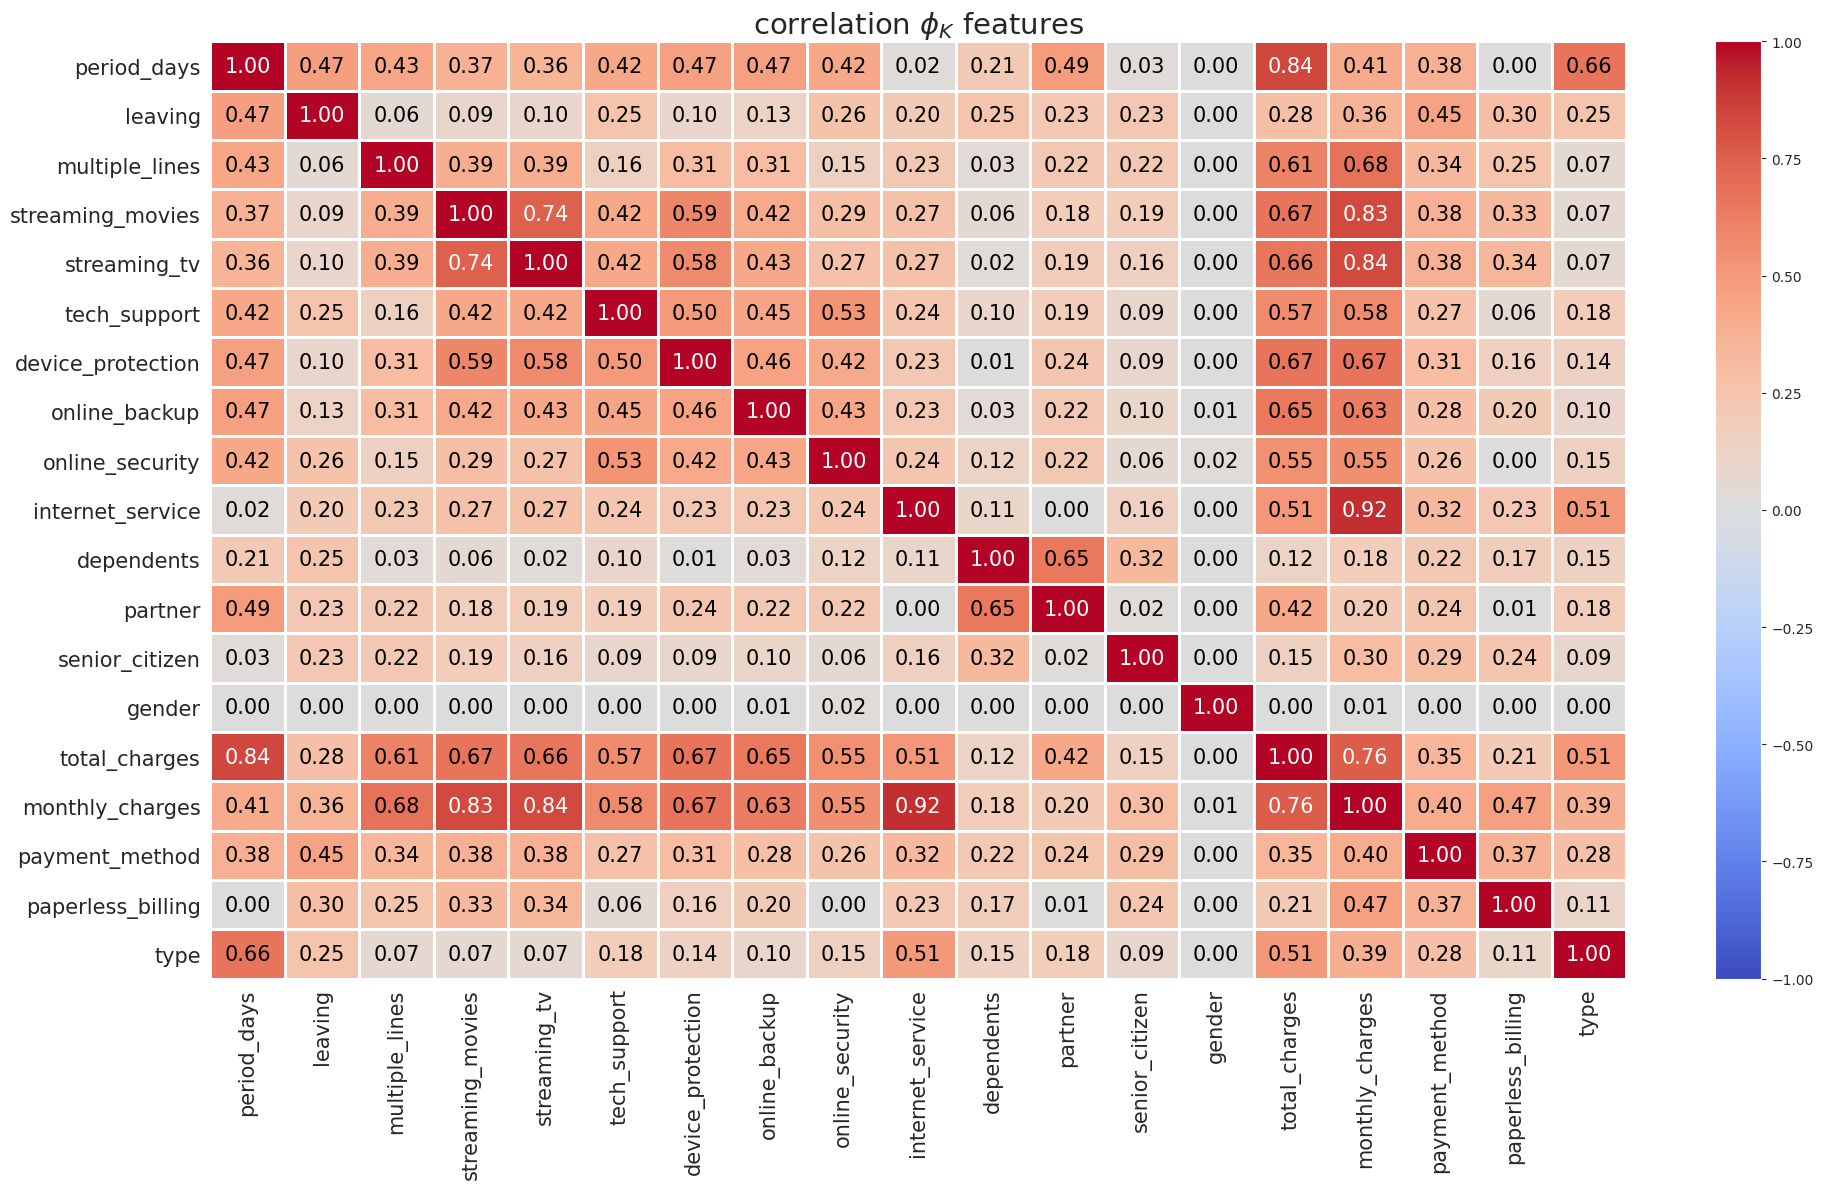

In [49]:
phik_overview = data.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=-1, 
                        vmax=1, 
                        color_map='coolwarm', 
                        title=r'correlation $\phi_K$ features', 
                        fontsize_factor=1.5,
                        figsize=(20,12))
plt.tight_layout()

The correlation matrix shows multicollinearity, especially between numerical and categorical features. Excluding these data with a small sample size can lead to a decrease in metric values when training models.

There is a significant imbalance in the classes of features. We will create a list of weights.

In [50]:
one_class_waight = data.loc[data['leaving'] == 1].shape[0] / data['leaving'].shape[0]
zero_class_waight = 1 - one_class_waight
class_waights = {0:zero_class_waight, 1:one_class_waight}
class_waights

{0: 0.7346301292063041, 1: 0.2653698707936959}

We will set random_state and test_size.

In [51]:
state = 261222
test_size = 1/3

We will form training and test samples.

In [52]:
train,test = train_test_split(data, 
                              test_size = test_size, 
                              random_state = state, 
                              stratify = data['leaving'])

In [53]:
def features_target_split(data,target):
    features = data.drop(target, axis=1)
    target = data[target]
    return features, target

In [54]:
features_test, target_test = features_target_split(test,'leaving')
features_train, target_train = features_target_split(train,'leaving')

In [55]:
features_train.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,period_days
2996,Month-to-month,1,Mailed check,60.599998,1156.349976,Female,0,0,0,DSL,1,0,1,0,0,0,1,549
129,One year,1,Electronic check,56.450001,3985.350098,Male,1,0,0,DSL,1,1,0,0,1,1,0,2163
3017,One year,1,Mailed check,61.500000,1087.449951,Female,0,1,1,DSL,1,1,0,1,0,0,0,549
1752,One year,0,Credit card (automatic),48.700001,1421.750000,Male,0,1,0,DSL,1,0,0,0,0,0,0,822
6842,One year,1,Mailed check,19.950001,257.000000,Male,0,0,0,No,0,0,0,0,0,0,0,396


We will use OHE encoding of categorical features and StandardScaler for numerical features.

In [56]:
ct = ColumnTransformer([
    ('numerical', StandardScaler(), make_column_selector(dtype_include=np.number)),
    ('categorical', OneHotEncoder(drop='first'), make_column_selector(dtype_include='category'))])

Conclusion:
* A list of weights has been created for balancing.
* The dataset is split into samples of 1/3, random_state = 261222.
* Categorical features are encoded using OHE, and numerical features using StandardScaler.
* A target binary feature and contract duration have been added.
* Non-informative features have been removed for further model training.
* Categorical features have been converted to binary.
* The data type of categorical features has been converted to cathegory for further OHE encoding of features.
* A phi-correlation matrix of the dependence of numerical and categorical features has been built.
* A significant imbalance in the classes of features has been detected.

## 3. Traning models.

### Logistic Regression

In [57]:
%%time
model_lr = LogisticRegression(random_state = state, 
                              class_weight = class_waights)

pipe_lr = make_pipeline(ct, model_lr)

parameters_lr = dict(logisticregression__C=np.arange(1, 200, 5), 
                     logisticregression__max_iter=np.arange(100, 1000, 100))

search_lr = RandomizedSearchCV(pipe_lr, 
                               parameters_lr,
                               scoring='roc_auc', 
                               cv = 5,
                               n_jobs=-1, 
                               random_state = state)

search_lr.fit(features_train, target_train)

best_score_lr = search_lr.best_score_
best_param_lr = search_lr.best_params_
best_lr = search_lr.best_estimator_

predict_lr = best_lr.predict(features_train)

#train_auc_roc_lr = roc_auc_score(target_train, predict_lr)
train_accuracy_lr = accuracy_score(target_train, predict_lr)
train_f1_lr = f1_score(target_train, predict_lr)

CPU times: user 336 ms, sys: 55.4 ms, total: 392 ms
Wall time: 4.93 s


In [58]:
print(f'AUC-ROC on the training sample: {best_score_lr:.4f}')
print(f'Accuracy on the training sample: {train_accuracy_lr:.4f}')
print(f'F1 on the training sample: {train_f1_lr:.4f}')
print(best_param_lr)

AUC-ROC on the training sample: 0.8448
Accuracy on the training sample: 0.7681
F1 on the training sample: 0.2617
{'logisticregression__max_iter': 600, 'logisticregression__C': 176}


### Decision Tree Classifier

In [59]:
%%time
model_dtc = DecisionTreeClassifier(random_state = state, 
                                   class_weight='balanced')

pipe_dtc = make_pipeline(ct, model_dtc)

parameters_dtc = dict(decisiontreeclassifier__max_depth=np.arange(10, 100, 5),
                      decisiontreeclassifier__min_samples_leaf=np.arange(3, 25, 1))

search_dtc = RandomizedSearchCV(pipe_dtc, 
                                parameters_dtc, 
                                scoring='roc_auc',
                                cv = 5, 
                                n_jobs=-1, 
                                random_state = state)

search_dtc.fit(features_train, target_train)

best_score_dtc = search_dtc.best_score_
best_param_dtc = search_dtc.best_params_

best_dtc = search_dtc.best_estimator_
predict_dtc = best_dtc.predict(features_train)

train_auc_roc_dtc = roc_auc_score(target_train, predict_dtc)
train_accuracy_dtc = accuracy_score(target_train, predict_dtc)
train_f1_dtc = f1_score(target_train, predict_dtc)

CPU times: user 261 ms, sys: 21.3 ms, total: 282 ms
Wall time: 3.48 s


In [60]:
print(f"AUC-ROC on the training sample: {best_score_dtc:.4f}")
print(f"Accuracy on the training sample: {train_accuracy_dtc:.4f}")
print(f"F1 on the training sample: {train_f1_dtc:.4f}")
print(best_param_dtc)

AUC-ROC on the training sample: 0.8336
Accuracy on the training sample: 0.7951
F1 on the training sample: 0.6889
{'decisiontreeclassifier__min_samples_leaf': 24, 'decisiontreeclassifier__max_depth': 35}


### Random Forest Regressor

In [61]:
%%time
model_rfc = RandomForestRegressor(random_state=state)

pipe_rfc = make_pipeline(ct, model_rfc)

parameters_rfc = dict(randomforestregressor__n_estimators=np.arange(1, 500, 50),
                      randomforestregressor__max_depth=np.arange(1, 70, 1),
                      randomforestregressor__min_samples_split=np.arange(1, 20, 1),
                      randomforestregressor__min_samples_leaf=np.arange(1, 20, 1))

search_rfc = RandomizedSearchCV(pipe_rfc, 
                                parameters_rfc, 
                                scoring='roc_auc',
                                cv = 5, 
                                n_jobs=-1, 
                                random_state = state)

search_rfc.fit(features_train, target_train)

best_score_rfc = search_rfc.best_score_
best_param_rfc = search_rfc.best_params_
best_rfc = search_rfc.best_estimator_
predict_rfc = best_rfc.predict(features_train)

train_auc_roc_rfc = roc_auc_score(target_train, predict_rfc)
#train_accuracy_rfc = accuracy_score(target_train, predict_rfc, normalize=False)
#train_f1_rfc = f1_score(target_train, predict_rfc)

CPU times: user 2.38 s, sys: 67.9 ms, total: 2.45 s
Wall time: 1min 18s


In [62]:
print(f"ROC-AUC on the training sample: {best_score_rfc:.4f}")
#print(f"Accuracy on the training sample: {train_accuracy_rfc:.4f}")
#print(f"F1 on the training sample: {train_f1_rfc:.4f}")
print(best_param_rfc)

ROC-AUC on the training sample: 0.8615
{'randomforestregressor__n_estimators': 151, 'randomforestregressor__min_samples_split': 15, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_depth': 41}


### CatBoost Classifier

In [63]:
%%time

catb = CatBoostClassifier(random_state = state, 
                          thread_count=1, 
                          auto_class_weights='Balanced')

parameters_cb = dict(depth=np.arange(3, 10, 1),
                     learning_rate=np.arange(0.1, 1, 0.1),
                     n_estimators=np.arange(100, 800, 50))

search_cb = RandomizedSearchCV(catb, 
                               parameters_cb, 
                               cv = 5, 
                               scoring='roc_auc', 
                               n_jobs=-1)

search_cb.fit(features_train, 
              target_train, 
              cat_features=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 
              verbose=0)

best_score_cb = search_cb.best_score_
best_cb = search_cb.best_estimator_
best_param_cb = search_cb.best_params_
predict_cb = best_cb.predict(features_train)

train_accuracy_cb = accuracy_score(target_train, predict_cb)
train_f1_cb = f1_score(target_train, predict_cb)

CPU times: user 2.42 s, sys: 110 ms, total: 2.53 s
Wall time: 1min 36s


In [64]:
print(f"ROC-AUC on the training sample: {best_score_cb:.4f}")
print(f"accuracy on the training sample: {train_accuracy_cb:.4f}")
print(f"f1 on the training sample: {train_f1_cb:.4f}")
print(best_param_cb)

ROC-AUC on the training sample: 0.9051
accuracy on the training sample: 0.8929
f1 on the training sample: 0.8187
{'n_estimators': 500, 'learning_rate': 0.2, 'depth': 3}


### LightGMB Classifier

In [73]:
%%time

lgbm = LGBMClassifier(random_state = state,
                      class_weight = 'balanced')

parameters_lgbm = dict(max_depth=np.arange(2, 20, 1), 
                       learning_rate=np.arange(0.1, 1, 0.05), 
                       n_estimators=np.arange(100, 700, 50), 
                       n_jobs=[1,-1])

search_lgbm = RandomizedSearchCV(lgbm, 
                                 parameters_lgbm, 
                                 cv = 10, 
                                 scoring='roc_auc', 
                                 n_jobs=-1)

search_lgbm.fit(features_train, 
                target_train, 
                categorical_feature=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 
                verbose=0)

best_score_lgbm = search_lgbm.best_score_
best_param_lgbm = search_lgbm.best_params_
best_lgbm = search_lgbm.best_estimator_
predict_lgbm = best_lgbm.predict(features_train)

train_auc_roc_lgbm = roc_auc_score(target_train, predict_lgbm)
train_accuracy_lgbm = accuracy_score(target_train, predict_lgbm)
train_f1_lgbm = f1_score(target_train, predict_lgbm)



CPU times: user 754 ms, sys: 32.8 ms, total: 787 ms
Wall time: 22.9 s


In [74]:
print(f"AUC-ROC on the training sample: {best_score_lgbm:.4f}")
print(f"Accuracy on the training sample: {train_accuracy_lgbm:.4f}")
print(f"F1 on the training sample: {train_f1_lgbm:.4f}")
print(best_param_lgbm)

AUC-ROC on the training sample: 0.9016
Accuracy on the training sample: 0.9252
F1 on the training sample: 0.8710
{'n_jobs': -1, 'n_estimators': 400, 'max_depth': 2, 'learning_rate': 0.7000000000000002}


In [75]:
result = pd.DataFrame(
    [best_score_lr, best_score_dtc, best_score_rfc, best_score_cb, best_score_lgbm], 
    index=['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestRegressor', 'CatBoostClassifier', 'LightGMBClassifier'], 
    columns=['ROC-AUC']
)
round(result, 4)

,ROC-AUC
LogisticRegression,0.8448
DecisionTreeClassifier,0.8336
RandomForestRegressor,0.8615
CatBoostClassifier,0.9051
LightGMBClassifier,0.9016


Based on the results of model training, CatBoost with a roc-auc metric on the training sample of 0.9051 is admitted to testing.

## 4. Testing models.

According to the results of model training, CatBoost shows a roc-auc metric value higher than 0.88 and is accepted for further testing.

### CatBoost Classifier

In [76]:
predict_cb_t = best_cb.predict(features_test)
train_auc_roc_cb_t = roc_auc_score(target_test, predict_cb_t)
train_accuracy_cb_t = accuracy_score(target_test, predict_cb_t)
train_f1_cb_t = f1_score(target_test, predict_cb_t)

print(f"AUC-ROC on the test sample: {train_auc_roc_cb_t:.4f}")
print(f"Accuracy on the test sample: {train_accuracy_cb_t:.4f}")
print(f"F1 on the test sample: {train_f1_cb_t:.4f}")

AUC-ROC on the test sample: 0.8331
Accuracy on the test sample: 0.8407
F1 on the test sample: 0.7313


The model on the test sample shows a roc-auc metric of 0.8331, which is lower than the declared threshold of roc-auc - 0.88. In view of this, we will try to improve the model metric by tuning the classification threshold.

In [77]:
def get_best_threshold(probabilities_one_test):

    best_f1 = 0
    best_treshold = 0

    for threshold in np.arange(0.1, 0.9, 0.1):
        predicted_valid = probabilities_one_test > threshold
        f1 = f1_score(target_test, predicted_valid)
        if (f1 > best_f1):
            best_f1 = f1
            best_threshold = threshold
            if (best_threshold >= 0.1 ):
                min_boundary = (best_threshold - 0.05)
                max_boundary = (best_threshold + 0.05)
                for updated_threshold in np.arange(min_boundary, max_boundary, 0.01):
                    predicted_valid = probabilities_one_test > updated_threshold
                    f1 = f1_score(target_test, predicted_valid)
                    if (f1 > best_f1):
                        best_f1 = f1
                        best_threshold = updated_threshold
                        
    return [best_f1, best_threshold]

In [78]:
def draw_graph_roc_curve(lst_with_old_f1_and_threshold, 
                         probabilities_one_test, 
                         model_name):
    
    def find_nearest_num(ar_for_search, val):
        idx = np.abs(ar_for_search - val).argmin()
        return ar_for_search.flat[idx]

    model_name = model_name
    max_val_tpr = 0
    min_val_fpr = 0
    best_f1 = lst_with_old_f1_and_threshold[2]
    best_threshold = lst_with_old_f1_and_threshold[1]
    old_f1 = lst_with_old_f1_and_threshold[0]
    auc_roc = roc_auc_score(target_test, probabilities_one_test)
    fpr, tpr, all_thresholds = roc_curve(target_test, probabilities_one_test)
    nearest_num = find_nearest_num(all_thresholds, best_threshold)
    a = np.where(all_thresholds == nearest_num)
    index = int(a[0])
    max_val_tpr = list(tpr)[index]
    min_val_fpr = list(fpr)[index]
    plt.figure(figsize=[15, 12])
    sns.set_style('darkgrid')
    plt.plot([0,1],
             [0,1], 
             linestyle ='--', 
             label='Constant model')
    plt.text((min_val_fpr + 0.02),(max_val_tpr + 0.02), 
             f'THRESHOLD - {best_threshold:.2f}, FPR - {min_val_fpr:.2f}, TPR - {max_val_tpr:.2f}',
             color='r',
             fontsize=16)
    plt.plot(fpr,
             tpr, 
             color='b', 
             label='ROC-curve')
    plt.plot([min_val_fpr],
             [max_val_tpr], 
             'o',
             color='r',
             label=f'Classification threshold - {best_threshold}', 
             markersize=15)
    plt.axvline(x=min_val_fpr, 
                color='r', 
                linestyle='--')
    plt.axhline(y=max_val_tpr, 
                color='r', 
                linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR', 
               fontsize=15)
    plt.ylabel('TPR', 
               fontsize=15)
    plt.figtext((min_val_fpr + 0.2), 
                (max_val_tpr - 0.10), 
                f'OLD_F1={old_f1:.2f}, NEW_F1={best_f1:.2f}, AUC_ROC={auc_roc:.2f}', 
                fontsize=17)
    plt.title(f'ROC-curve for {model_name}', 
              fontsize=17)
    plt.grid(True)
    plt.legend(edgecolor = 'r', 
               facecolor = 'oldlace')
    plt.show();
    return auc_roc

In [79]:
probalities_test_cbc = best_cb.predict_proba(features_test)
probabilities_one_test_cbc = probalities_test_cbc[:,1]
best_test_f1, best_threshold_cbc = get_best_threshold(probabilities_one_test_cbc)

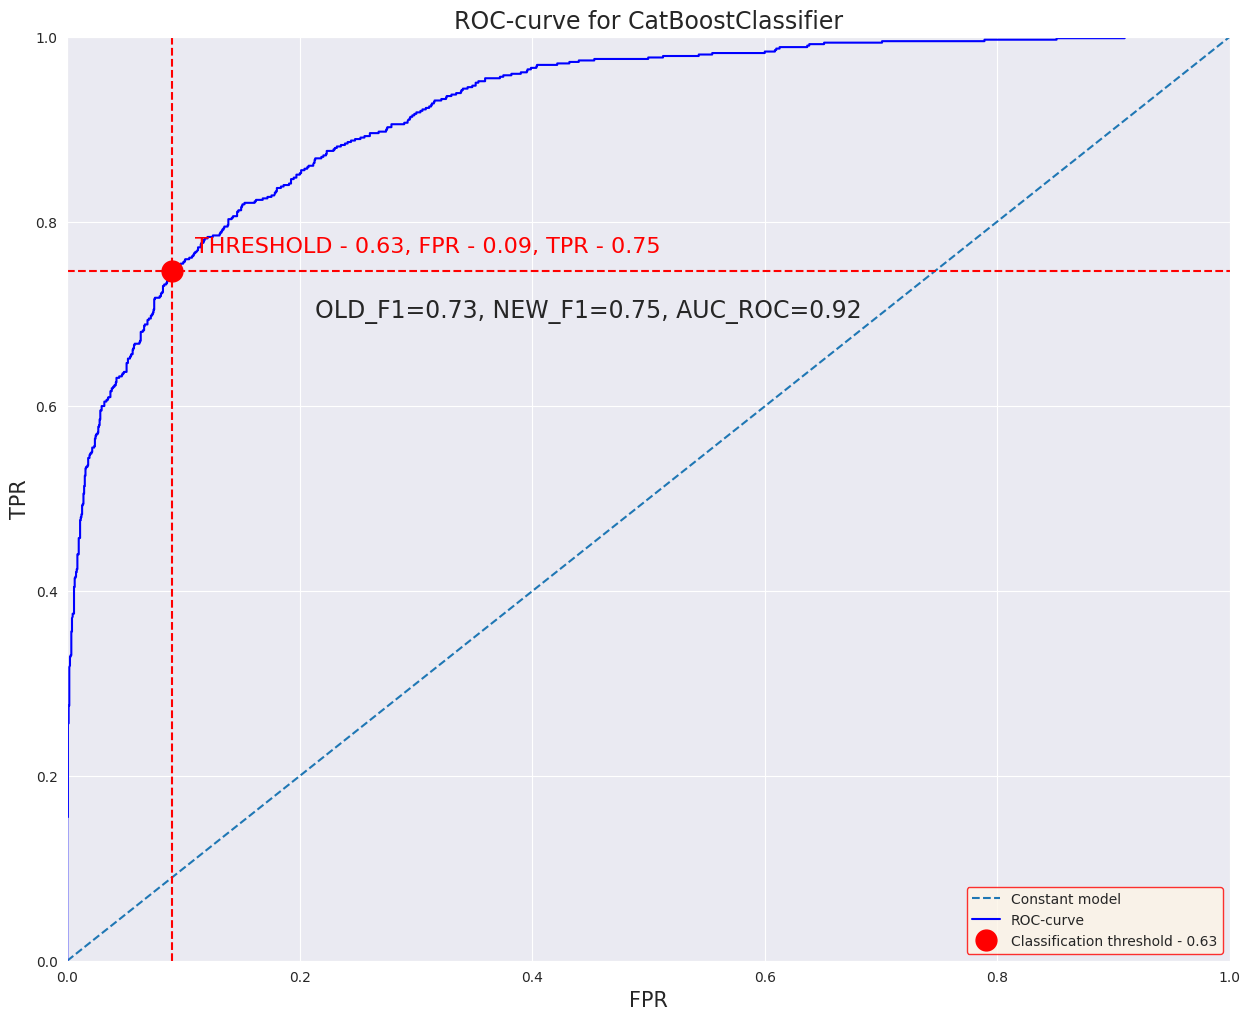

ROC-AUC on the test sample: 0.9199


In [80]:
old_f1_test_cbc = f1_score(target_test, 
                           best_cb.predict(features_test))
test_auc_roc = draw_graph_roc_curve([old_f1_test_cbc, best_threshold_cbc, best_test_f1], 
                                    probabilities_one_test_cbc, 
                                    'CatBoostClassifier')
print(f"ROC-AUC on the test sample: {test_auc_roc:.4f}")

## 5. Overall conclusion.

Four datasets were received for work. After preliminary data preparation and merging into one common dataset, no data errors or anomalies were detected, and no duplicates were detected either. 

String features were encoded using direct coding techniques. A class imbalance of the features was identified, and a list of weights was calculated for model optimization. 

The following models were chosen for training: LogisticRegression, DecisionTreeClassifier, RandomForestRegressor, CatBoostClassifier, and LightGMBClassifier. As a result of training on the training sample, CatBoostClassifier was admitted to testing due to the exceeding of the roc-auc value above 0.92. 

During testing, the specified models showed a result below the declared roc-auc threshold of 0.88. To improve the metric, a classification threshold was iterated, which allowed to improve the result with a clear leader CatBoostClassifier with a roc-auc metric value of 0.9199 by 10.7% and set of hyperparameters {'n_estimators': 500, 'learning_rate': 0.2, 'depth': 3}.